# CelebA Semantic Loss Model
#### Research Project - Diego Becerra Merodio 5459117
In this Jupyter Notebook, we will train a Semantic Loss model with task of recognizing the different features labeled by the CelebA dataset. This dataset takes images of celebrities and identifies 40 different attributes from their facial features. Using the following image, we identified the correlation between the attributes and derived the predicates for the Semantic Loss model.

<img src="images/CelebA_correlation.png" alt="CelebA Sample" width="600"/>

The first step is to declare and import all dependencies

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from semantic_loss_pytorch import SemanticLoss
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch import optim
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, Subset
from torch.utils.data import Dataset

After this, we can defined our custom data set for a semisupervised CelebA data set and a model for our neural network

In [5]:
# === Dataset ===
class SemiSupervisedCelebA(Dataset):
    def __init__(self, dataset, labeled_ratio=0.1):
        self.dataset = dataset

        # Get subset indices
        subset_indices = dataset.indices
        full_attrs = dataset.dataset.attr.clone()  # shape: [N, 40]

        # Only use attributes for the subset
        self.attrs = full_attrs[subset_indices]
        self.attrs[self.attrs == -1] = 0

        # Create label mask
        self.labeled_mask = torch.zeros(len(self.attrs), dtype=torch.bool)
        labeled_count = int(len(self.attrs) * labeled_ratio)
        labeled_indices = torch.randperm(len(self.attrs))[:labeled_count]
        self.labeled_mask[labeled_indices] = True

        # Mask unlabeled attributes by setting to -1
        self.attrs[~self.labeled_mask] = -1

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        label = self.attrs[idx]  # shape: [40], with values 0, 1, or -1
        has_label = self.labeled_mask[idx]
        return image, label, has_label

# === Model ===
class CelebANet(nn.Module):
    def __init__(self, num_attrs=40):
        super(CelebANet, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*64*3, 512),
            nn.ReLU(),
            nn.Linear(512, num_attrs),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

Afterwards, we can declare our hyperparameters for the model and load and preprocess our data to be ready to use with the model we have previously declared.

In [6]:
# === Hyperparameters ===
BATCH_SIZE = 64
EPOCHS = 5
NUM_ATTRS = 40
TEST_SIZE = 0.2
SL_WEIGHT = 0.3
LABELED_RATIO = 0.02
LR = 0.001

# === Load CelebA ===
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to manageable size
    transforms.ToTensor()
])

full_dataset = CelebA(root='../data', target_type='attr', download=False, transform=transform)

# === Split into Train and Validation Sets ===
train_idx, val_idx = train_test_split(
    range(len(full_dataset)),
    test_size=TEST_SIZE,
    stratify=full_dataset.attr[:, 20])

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
semi_supervised_dataset = SemiSupervisedCelebA(train_dataset, LABELED_RATIO)

train_loader = DataLoader(semi_supervised_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Here is a simple visualization of our data set

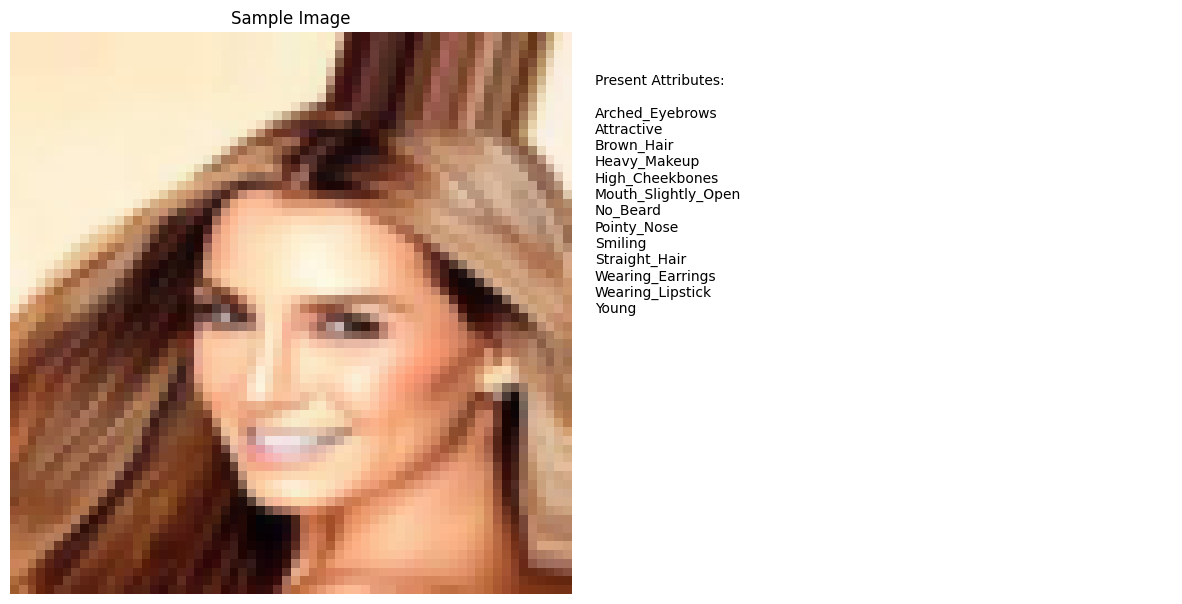

In [7]:
# Visualize a sample
# Define attribute names
attr_names = [
    '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald',
    'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
    'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
    'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache',
    'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose',
    'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
    'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
    'Wearing_Necklace', 'Wearing_Necktie', 'Young'
]

# Visualize a sample
img, attr = full_dataset[0]
plt.figure(figsize=(12, 6))

# Plot image on the left
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.title("Sample Image")
plt.axis('off')

# Plot attributes on the right
plt.subplot(1, 2, 2)
present_attrs = [name for i, name in enumerate(attr_names) if attr[i] == 1]
plt.text(0, 0.5, "Present Attributes:\n\n" + "\n".join(present_attrs), fontsize=10)
plt.axis('off')

plt.tight_layout()
plt.show()

After this we can define our model

In [8]:
model = CelebANet()
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.BCELoss()
semantic_loss = SemanticLoss('constraints/celebA_constraints.sdd', 'constraints/celebA_constraints.vtree')

### Constraints
The following constraints were identified and implemented in the semantic loss model:

1. Hair Color Exclusivity:
   - A person cannot have black hair and blond hair simultaneously
   - A person cannot have black hair and brown hair simultaneously
   - A person cannot have blond hair and brown hair simultaneously
   - A person cannot have gray hair and any other hair color

2. Gender-Based Constraints:
   - Males typically do not wear heavy makeup
   - Males typically do not wear lipstick
   - Males typically have no bangs
   - Males typically do not wear earrings

3. Facial Hair Relationships:
   - No beard implies no goatee and no mustache
   - Having a goatee or mustache implies having facial hair (not no beard)
   - Having a goatee implies having facial hair
   - Having a mustache implies having facial hair

4. Facial Feature Correlations:
   - Heavy makeup is often associated with wearing lipstick
   - Bald people typically have no bangs
   - People with receding hairlines typically do not have bangs

5. Accessory Relationships:
   - Wearing a hat often means no earrings are visible
   - Wearing a necktie is more common in males

These constraints help guide the model to make more logically consistent predictions about facial attributes.

We finally get to train and evaluate the model

In [12]:
# === Training Loop ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    labeled = 0
    unlabeled = 0
    for images, attrs, is_labeled in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch"):
        preds = model(images)  # shape: [batch_size, 40]

        loss_bce = torch.tensor(0.0, requires_grad=True, device=preds.device)

        if is_labeled.any():
            labeled_preds = preds[is_labeled]
            labeled_attrs = attrs[is_labeled].float()
            loss_bce = loss_fn(labeled_preds, labeled_attrs)

        loss_sem = semantic_loss(probabilities=preds)

        loss_sum = loss_bce + SL_WEIGHT * loss_sem
        optimizer.zero_grad()
        loss_sum.backward()
        optimizer.step()

        total_loss += loss_sum.item()

        num_labeled = is_labeled.sum().item()
        num_unlabeled = (~is_labeled).sum().item()

        labeled += num_labeled
        unlabeled += num_unlabeled

    print(f"Epoch {epoch+1}/{EPOCHS}, Labeled: {labeled}, Unlabeled: {unlabeled}")

    # === Evaluation ===
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, attrs in val_loader:
            attrs[attrs == -1] = 0
            preds = model(images)
            preds_binary = (preds > 0.5).float()
            correct += (preds_binary == attrs).sum().item()
            total += torch.numel(attrs)

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/5: 100%|██████████| 2035/2035 [01:17<00:00, 26.31batch/s]


Epoch 1/5, Labeled: 2604, Unlabeled: 127612
Validation Accuracy: 83.0588


Epoch 2/5: 100%|██████████| 2035/2035 [01:09<00:00, 29.30batch/s]


Epoch 2/5, Labeled: 2604, Unlabeled: 127612
Validation Accuracy: 83.0158


Epoch 3/5: 100%|██████████| 2035/2035 [00:59<00:00, 34.41batch/s]


Epoch 3/5, Labeled: 2604, Unlabeled: 127612
Validation Accuracy: 83.6489


Epoch 4/5: 100%|██████████| 2035/2035 [01:00<00:00, 33.71batch/s]


Epoch 4/5, Labeled: 2604, Unlabeled: 127612
Validation Accuracy: 84.0044


Epoch 5/5: 100%|██████████| 2035/2035 [00:59<00:00, 34.17batch/s]


Epoch 5/5, Labeled: 2604, Unlabeled: 127612
Validation Accuracy: 84.2503
